## Evolution of Object Detection and Localization Algorithms 
### Code implementation on Pascal VOC dataset and ResNet for transfer learning

The codes used in this notebook is executing the ideas presented in below shared blog. Almost all of the content in this notebook is taken from **Jeremy Howard's fast.ai** deep learning part 2 course. The blog was motivated from **Andrew Ng's deeplearning.ai** CNN course. I would recommend you to go through below blogpost to develop the intuitive understanding before diving into the codes.

https://towardsdatascience.com/evolution-of-object-detection-and-localization-algorithms-e241021d8bad

### Data Preprocessing

#### Libraries used

In [10]:
#! ln -s ../fastai/fastai/ .

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Install `fastai` library by following instructions mentioned in below link

https://github.com/fastai/fastai

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from IPython.display import Image
from matplotlib import patches, patheffects

In [3]:
# check to make sure you set the device
#torch.cuda.set_device(0)  # set.device(0) to work on CPU

#### Understanding Pascal VOC data
http://host.robots.ox.ac.uk/pascal/VOC/voc2007/

First of all, download the Pascal VOC data by running below 2 lines of codes. After running, I commented it out

In [4]:
#!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar

In [5]:
#!wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip

In [6]:
# Use to move image data from 2nd link to PASCAL_VOC from 1st link
# ! mv pascal_data/VOCdevkit/VOC2007 pascal_data/PASCAL_VOC/

Let's try to visualize the training data, which contains data about **class** of an image and **bounding box** related data in each image. Bounding box data contains **height, width, top left coordinate, top right coordinate** around each object in image

In [7]:
! ls pascal_data/PASCAL_VOC/  # json (bbox, class, image id)

VOC2017               pascal_train2007.json pascal_val2007.json
pascal_test2007.json  pascal_train2012.json pascal_val2012.json


In [8]:
PATH = Path('pascal_data/PASCAL_VOC/')

In [9]:
list(PATH.iterdir())

[PosixPath('pascal_data/PASCAL_VOC/pascal_test2007.json'),
 PosixPath('pascal_data/PASCAL_VOC/pascal_train2007.json'),
 PosixPath('pascal_data/PASCAL_VOC/pascal_train2012.json'),
 PosixPath('pascal_data/PASCAL_VOC/pascal_val2007.json'),
 PosixPath('pascal_data/PASCAL_VOC/pascal_val2012.json'),
 PosixPath('pascal_data/PASCAL_VOC/VOC2017')]

I am going to use training data from `pascal_train2007.json` as I am working on CPU and it has relatively small amount of data. If anyone is working on GPU, feel free to use 2012 data also. Let's see how it looks like

In [10]:
train_json = json.load((PATH/'pascal_train2007.json').open()) #  PATH.open() creates a io.text wrapper that is like file path

In [11]:
train_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

What's there in each of those keys. Let's see one by one

In [12]:
train_json['images'][:2]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480}]

`images` has data about `image ids` and `image files`. Let's see where are these images. e.g. `000012.jpg`. 
(They are present in `VOC2007/` as can be seen in above ls statement)

Let's just move `VOC2007` into `PASCAL_VOC` to make it accessible via PATH iterator

In [13]:
# ! mv pascal_data/VOCdevkit/VOC2007 pascal_data/PASCAL_VOC/

In [14]:
JPEGS = 'VOC2017/JPEGImages'

In [15]:
IMAGE_PATH = PATH/JPEGS

In [16]:
list(IMAGE_PATH.iterdir())[:4]  

[PosixPath('pascal_data/PASCAL_VOC/VOC2017/JPEGImages/000005.jpg'),
 PosixPath('pascal_data/PASCAL_VOC/VOC2017/JPEGImages/000007.jpg'),
 PosixPath('pascal_data/PASCAL_VOC/VOC2017/JPEGImages/000009.jpg'),
 PosixPath('pascal_data/PASCAL_VOC/VOC2017/JPEGImages/000012.jpg')]

So, here are our jpg images. 

Let's now look at other 3 keys of `train_json`

In [17]:
train_json['type'] # doesn't interest me

'instances'

In [18]:
train_json['annotations'][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

Ok. So, it has `bbox` data, `id` of image to map with `jpg` using `images` key. `category_id` as final label. Categori ID has name in `categories` key. Let's take a look

In [19]:
train_json['categories']

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'},
 {'id': 5, 'name': 'bottle', 'supercategory': 'none'},
 {'id': 6, 'name': 'bus', 'supercategory': 'none'},
 {'id': 7, 'name': 'car', 'supercategory': 'none'},
 {'id': 8, 'name': 'cat', 'supercategory': 'none'},
 {'id': 9, 'name': 'chair', 'supercategory': 'none'},
 {'id': 10, 'name': 'cow', 'supercategory': 'none'},
 {'id': 11, 'name': 'diningtable', 'supercategory': 'none'},
 {'id': 12, 'name': 'dog', 'supercategory': 'none'},
 {'id': 13, 'name': 'horse', 'supercategory': 'none'},
 {'id': 14, 'name': 'motorbike', 'supercategory': 'none'},
 {'id': 15, 'name': 'person', 'supercategory': 'none'},
 {'id': 16, 'name': 'pottedplant', 'supercategory': 'none'},
 {'id': 17, 'name': 'sheep', 'supercategory': 'none'},
 {'id': 18, 'name': 'sofa', 'supercategory': 'none'},
 {'id': 

It has only **20 unique** categories in data

How much is total training data?

In [20]:
len(list(IMAGE_PATH.iterdir()))

5011

#### Visualizing images with bounding boxes

 The bbox field specifies the bounding box of the object in the image, as `[left,top,right,bottom]`

In [21]:
def show_img(im, figsize=None, ax=None):
    """
    Wrapper to make use of subplots to show images. (no need x axis, y axis lines when we are showing images)
    
    Input:
    im: input image that we want to show
    
    Returns:
    ax: matplotlib axis element that can be used later if we want to change linewidth/text in that
    """
    
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [22]:
def draw_outline(o, lw):
    """
    Draws outline around text/ bounding box
    
    To make text/ bounding boxes visible in any image, we use thick white colored bounding box with black outline.
    
    Input:
    o: bbox patch or text box
    lw: Float. Thickness of text/ bbox
    """
    
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

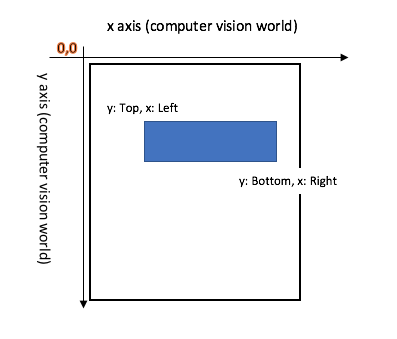

In [23]:
Image('image_bbox.png')

* In below function, we are switching the x,y coordinates to y,x. Why?
Because in computer vision world, when we say 640x480, it means width by height of screen. 
But in math world, when we talk about array, 640, 480 would be rows, columns which translates to height, width. 

So we are changing format of computer vision world to math/numpy world to make it easier for to think of dimensions later. 

As quoted by Jeremy here : https://youtu.be/b8D6Bwck9QM?t=3596

In [24]:
def bb_hw(b):
    """
    Return bbox in y,x, height, width format. 
   
    Input: 
    b: bbox are given from pascal voc dataset
    
    Returns:
    1st: Y coordinate of origin (top left when we look at image)
    2nd: X coordinate of origin (top left when we look at image)
    3rd: Height of bbox
    4th: Width of bbox
    """
    return (b[1], b[0], b[3] - b[1], b[2] - b[0])

In [25]:
def draw_rect(ax, b):
    """
    Draws bounding box rectangle on image. (also uses draw_outline() to make white bbox with black outline)
    
    Input:
    b: output of bb_hw
    
    Returns:
    4 args of Rectance = (x,y) , width, height
    """
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:],  fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [26]:
def draw_text(ax, xy, txt, sz=14):
    """
    Draws text on image
    
    Input:
    ax: Output of show_img() function
    xy: x,y coordinates of image
    txt: text we want to show. generally name of class like "car"
    sz = fontsize
    """
    
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

Let's get some image. To make our life easier, let's give strings a name. So that we can use `tab` to complete the sentences. Also let's make dictionary of 

In [27]:
image_sample = train_json['images'][0]['file_name'] 

In [28]:
image_sample 

'000012.jpg'

In [29]:
image_sample_id = train_json['images'][0]['id']

In [30]:
image_sample_id

12

Let's save `annotations` (bbox data) and `class` for each image in a dictionary for easy mapping

In [102]:
# get bbox and object name for this image id
train_annotation = collections.defaultdict(lambda : []) # 

for i in train_json['annotations']:
    if not i['ignore']:
        bb = i['bbox']
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1]) # same format as discussed in bb_hw() 
        train_annotation[i['image_id']].append((bb, i['category_id']))

In [103]:
train_annotation[image_sample_id] # here 12 is image id, 7 is category id

[(array([ 96, 155, 269, 350]), 7)]

In [104]:
train_annotation[image_sample_id][0]

(array([ 96, 155, 269, 350]), 7)

In [34]:
category_id = train_annotation[image_sample_id][0][1] - 1 # -1 because category ids start from 1. python index starts from 0

In [35]:
IMAGE_PATH/'000012.jpg'

PosixPath('pascal_data/PASCAL_VOC/VOC2017/JPEGImages/000012.jpg')

In [36]:
im = open_image(IMAGE_PATH/image_sample)

In [37]:
train_annotation[image_sample_id][0][0]

array([ 96, 155, 269, 350])

Ok. let's wrap it all up. i.e function to draw an image in a function

In [38]:
def draw_im(im, ann):
    """
    Input:
    im: Image array
    ann: Array of annotations (bbox + category_id) as saved in "train_annotations" dictionary

    """
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [39]:
# dictionary object to index image name. used to open image array

train_imagename = dict((o['id'], o['file_name']) for o in train_json['images'])

# dictionary to map id with category name
cats = dict((o['id'], o['name']) for o in train_json['categories'])


In [138]:
def draw_idx(i, annotation_dict = train_annotation):
    """
    Input: 
    i: Image index we want to display
    annotation_dict: dictionary of annotation used (defining here as in next section we will used different one)
    
    Returns:
    Image with text and bbox
    """
    
    image_a = annotation_dict[i] # annotation of image index i
    file_name = train_imagename[i]
    im = open_image(IMAGE_PATH/file_name)
    print(im.shape)
    if annotation_dict == train_annotation: draw_im(im, image_a) # some formatting issue while plotting next one
    elif annotation_dict == train_largest_annotation: draw_im(im, [(image_a)])

In [139]:
train_annotation[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

(364, 480, 3)


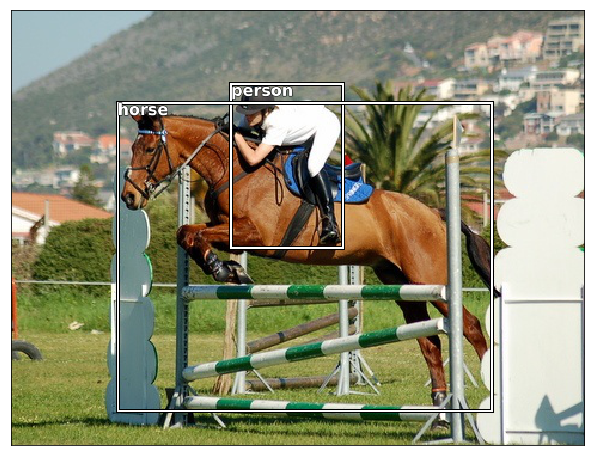

In [140]:
draw_idx(17)

### Task 1. Image Classification

As talked in the blog, first we would like to classify **largest** object in the image. This is a basic **Convolution Neural Network** problem, which will have softmax layer at the end. The output will give the probability of input image being in one of the classes

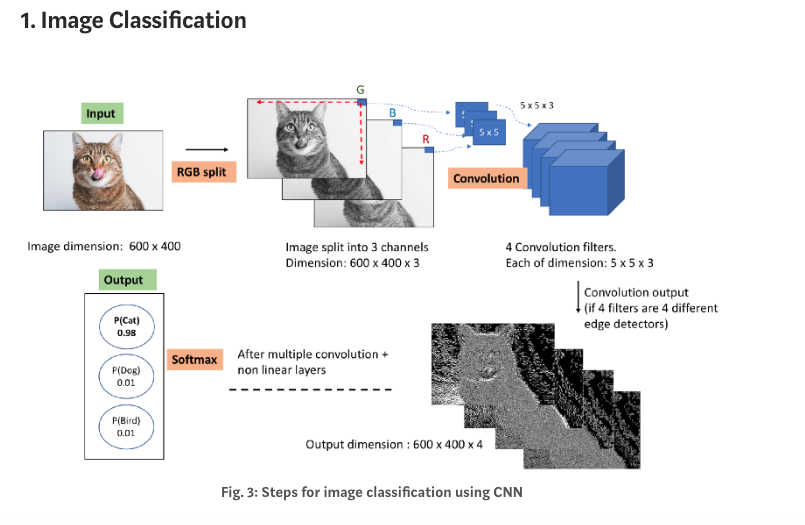

In [44]:
Image('image_class.png')

To be clear, I am going to use `fast.ai` functions to learn network for this problem (actually transfer learning). Infact all the codes are taken from fast.ai dl part 2 course. The fast.ai library is built on top of `PyTorch`

* **Some things to keep in mind**: 
    * We need to classify largest object. But in train_json, we have data about all the bounding boxes. But we can find which one has largest area and train on that
    * We are going to do transfer learning using ResNEt

In [48]:
train_annotation[23]

[(array([229,   8, 499, 244]), 2),
 (array([219, 229, 499, 333]), 2),
 (array([  0,   1, 368, 116]), 15),
 (array([  1,   2, 461, 242]), 15),
 (array([  0, 224, 485, 333]), 15)]

(500, 334, 3)


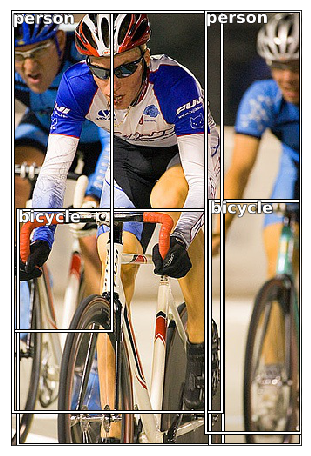

In [57]:
draw_idx(23)

2 bikes and 3 person are recognised. But let's just focus on largest object, which is this person

In [105]:
# Largest object in each image

def get_largest_bb(bb_arr):
    """
    Returns only 1 bbox which has largest area
    Area will be height*width. We have already saved height and width in 3rd and 4th elements in train_annotations. 
    Just multiply those
    """
    
    return bb_arr[np.argmax([bb[0][2]*bb[0][3] for bb in bb_arr ])]
    

In [106]:
get_largest_bb(train_annotation[23])

(array([219, 229, 499, 333]), 2)

Making new array `train_largest_annotation` which has only 1 largest bbox

{
    IMG_ID : largest bounding box,
    ...
}

In [122]:
train_largest_annotation = {a: get_largest_bb(b) for a,b in train_annotation.items()}

In [123]:
train_largest_annotation[23]

(array([219, 229, 499, 333]), 2)

In [142]:
train_annotation[23]

[(array([229,   8, 499, 244]), 2),
 (array([219, 229, 499, 333]), 2),
 (array([  0,   1, 368, 116]), 15),
 (array([  1,   2, 461, 242]), 15),
 (array([  0, 224, 485, 333]), 15)]

(500, 334, 3)


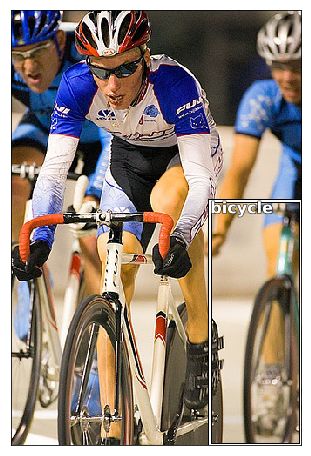

In [141]:
draw_idx(23, train_largest_annotation)